In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from sklearn.model_selection import train_test_split

In [2]:
def timeStepsList():
    timeStepsList = np.loadtxt("timeStepsList.txt", dtype=str)
    index = np.argsort(timeStepsList.astype('float32'))
    timeStepsList = timeStepsList[index]
    return list(timeStepsList)

In [3]:
def readFile(filename, sz):
    res = []
    data = pd.read_csv(filename, header=None, skiprows=23, nrows=sz, dtype=str)
    data = data.iloc[:, 0].str.replace('[(,)]', '', regex=True)
    for row in data:
        row = row.split()
        data = []
        for val in row:
            data.append(float(val))
        res.append(data)
    return np.array(res)

In [4]:
def normalize(x):
    return x/(np.max(abs(x), axis=0)+0.00000001)

In [5]:
def formDataset(*args):
    return Variable(torch.tensor(normalize(np.concatenate(args, axis=1))).type(torch.FloatTensor), requires_grad=True)

In [6]:
def writePredict(pred, folder):
    with open('patterns/dUPatternBeginning', 'r') as f:
        dUPatternBeginning = f.readlines()
        
    with open('patterns/dUPatternEnding', 'r') as f:
        dUPatternEnding = f.readlines()
        
    with open('patterns/dpPatternBeginning', 'r') as f:
        dpPatternBeginning = f.readlines()
        
    with open('patterns/dpPatternEnding', 'r') as f:
        dpPatternEnding = f.readlines()
    
    fU = open(folder + 'dU', 'w')
    fp = open(folder + 'dp', 'w')
    
    fU.writelines(dUPatternBeginning)
    fU.write(f'{len(pred)}\n(\n')
    fp.writelines(dpPatternBeginning)
    fp.write(f'{len(pred)}\n(\n')
    
    for val in pred:
        fU.write(f'({val[0].item()} {val[1].item()} {val[2].item()})\n')
        fp.write(f'{val[3].item()}\n')
        
    fU.writelines(dUPatternEnding)
    fp.writelines(dpPatternEnding)
    
    fU.close()
    fp.close()

In [7]:
sz = 2785000 # 139100

In [8]:
%%time

times = timeStepsList()
foldersRes = [f'TPF{time}/res/' for time in times]
foldersRef = [f'TPF{time}/ref/' for time in times]
    
IsRes = [np.concatenate([readFile(folder+filename, sz) for folder in foldersRes], axis=0) for filename in [f'I{i}' for i in range(5)]]
TsRes = [np.concatenate([readFile(folder+filename, sz) for folder in foldersRes], axis=0) for filename in [f'T{i}' for i in range(10)]]
URes = np.concatenate([readFile(folder + 'U', sz) for folder in foldersRes], axis=0)
pRes = np.concatenate([readFile(folder + 'p', sz) for folder in foldersRes], axis=0)
# gradPRes = np.concatenate([readFile(folder + 'gradP', sz) for folder in foldersRes], axis=0)
# gradURes = np.concatenate([readFile(folder + 'gradU', sz) for folder in foldersRes], axis=0)
inv1GradURes = np.concatenate([readFile(folder + 'inv1GradU', sz) for folder in foldersRes], axis=0)
inv2GradURes = np.concatenate([readFile(folder + 'inv2GradU', sz) for folder in foldersRes], axis=0)
magGradPRes = np.concatenate([readFile(folder + 'magGradP', sz) for folder in foldersRes], axis=0)
rotationRateTensorRes = np.concatenate([readFile(folder + 'rotationRateTensor', sz) for folder in foldersRes], axis=0)
strainRateTensorRes = np.concatenate([readFile(folder + 'strainRateTensor', sz) for folder in foldersRes], axis=0)

URef = np.concatenate([readFile(folder + 'U', sz) for folder in foldersRef], axis=0)
pRef = np.concatenate([readFile(folder + 'p', sz) for folder in foldersRef], axis=0)

CPU times: user 7min 48s, sys: 19.5 s, total: 8min 7s
Wall time: 8min 26s


In [9]:
not_interesting_indexes = np.random.choice(np.where(abs(URes.transpose()[1]) <= 0.2)[0], 100000, replace=False)
interesting_indexes = np.where(abs(URes.transpose()[1]) > 0.2)[0]
len(interesting_indexes), len(not_interesting_indexes)

(146913, 50000)

In [10]:
for i in range(len(IsRes)):
    IsRes[i] = np.concatenate([IsRes[i][interesting_indexes], IsRes[i][not_interesting_indexes]], axis=0)
for i in range(len(TsRes)):
    TsRes[i] = np.concatenate([TsRes[i][interesting_indexes], TsRes[i][not_interesting_indexes]], axis=0)
URes = np.concatenate([URes[interesting_indexes], URes[not_interesting_indexes]], axis=0)
pRes = np.concatenate([pRes[interesting_indexes], pRes[not_interesting_indexes]], axis=0)
inv1GradURes = np.concatenate([inv1GradURes[interesting_indexes], inv1GradURes[not_interesting_indexes]], axis=0)
inv2GradURes = np.concatenate([inv2GradURes[interesting_indexes], inv2GradURes[not_interesting_indexes]], axis=0)
magGradPRes = np.concatenate([magGradPRes[interesting_indexes], magGradPRes[not_interesting_indexes]], axis=0)
rotationRateTensorRes = np.concatenate([rotationRateTensorRes[interesting_indexes], rotationRateTensorRes[not_interesting_indexes]], axis=0)
strainRateTensorRes = np.concatenate([strainRateTensorRes[interesting_indexes], strainRateTensorRes[not_interesting_indexes]], axis=0)
URef = np.concatenate([URef[interesting_indexes], URef[not_interesting_indexes]], axis=0)
pRef = np.concatenate([pRef[interesting_indexes], pRef[not_interesting_indexes]], axis=0)

In [11]:
nonTensorInput = formDataset(*IsRes, pRes, inv1GradURes, inv2GradURes, magGradPRes)
tensorInput = formDataset(*TsRes)

In [12]:
target = Variable(torch.tensor(np.concatenate((URef, pRef), axis=1) - np.concatenate((URes, pRes), axis=1)).type(torch.FloatTensor), requires_grad=True)

In [62]:
class TBNN(nn.Module):
    
    def __init__(self, hiddenLayerNeurons=256):
        super(TBNN, self).__init__()
        self.fc1 = nn.Linear(len(nonTensorInput[0]), hiddenLayerNeurons, dtype=torch.float32)
        self.fc2 = nn.Linear(hiddenLayerNeurons, len(tensorInput[0]), dtype=torch.float32)
        self.fc3 = nn.Bilinear(len(tensorInput[0]), len(tensorInput[0]), 4)
        
    def forward(self, x1, x2):
        x = F.tanh(self.fc1(x1))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x, x2)
        return x

In [63]:
def fit(model, optimizer, criterion, x1, x2, y, test_size=0.1, train=True, shuffle=True, batch_size=100):

    assert len(x1) == len(x2) == len(y)
    
    x1train, x1test, x2train, x2test, ytrain, ytest = train_test_split(x1, x2, y, shuffle=shuffle, test_size=test_size)
    
    model.train(train)                                            # важно для Dropout, BatchNorm
    sumLtrain, Ltest, numB = 0, 0, int(len(x1train)/batch_size)   # ошибка, количество батчей
       
    for i in range(0, numB*batch_size, batch_size):          
        x1b = x1train[i: i+batch_size]                            # текущий батч,
        x2b = x2train[i: i+batch_size]
        yb = ytrain[i: i+batch_size]                              # x1, x2, y - torch тензоры
        
        y_ = model(x1b, x2b)                                      # прямое распространение
        L = criterion(y_, yb)                                     # вычисляем ошибку
  
        if train:                                                 # в режиме обучения
            optimizer.zero_grad()                                 # обнуляем градиенты        
            L.backward(retain_graph=True)                         # вычисляем градиенты            
            optimizer.step()                                      # подправляем параметры
                                     
        sumLtrain += L.item()                                     # суммарная ошибка (item из графа)
         
    model.train(False)
    Ltest = criterion(model(x1test, x2test), ytest).item()
            
    return sumLtrain/numB, Ltest                                  # средняя ошибка

In [64]:
# models = [TBNN(i) for i in [8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]] # 1024 best
# models
model = TBNN(1024)

In [65]:
# optimizers = [optim.SGD(model.parameters(), lr=0.001, momentum=0.9) for model in models]
# criterions = [nn.L1Loss() for i in range(len(models))]
# optimizers, criterions
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.L1Loss()
optimizer, criterion

(SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.001
     maximize: False
     momentum: 0.9
     nesterov: False
     weight_decay: 0
 ),
 L1Loss())

In [66]:
epochs = 100

In [67]:
lossesTrain, lossesTest = [], []
for epoch in tqdm(range(epochs)):
    lTrain, lTest = fit(model, optimizer, criterion, nonTensorInput, tensorInput, target, batch_size=5000)
    lossesTrain.append(lTrain)
    lossesTest.append(lTest)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:16<00:00,  4.36s/it]


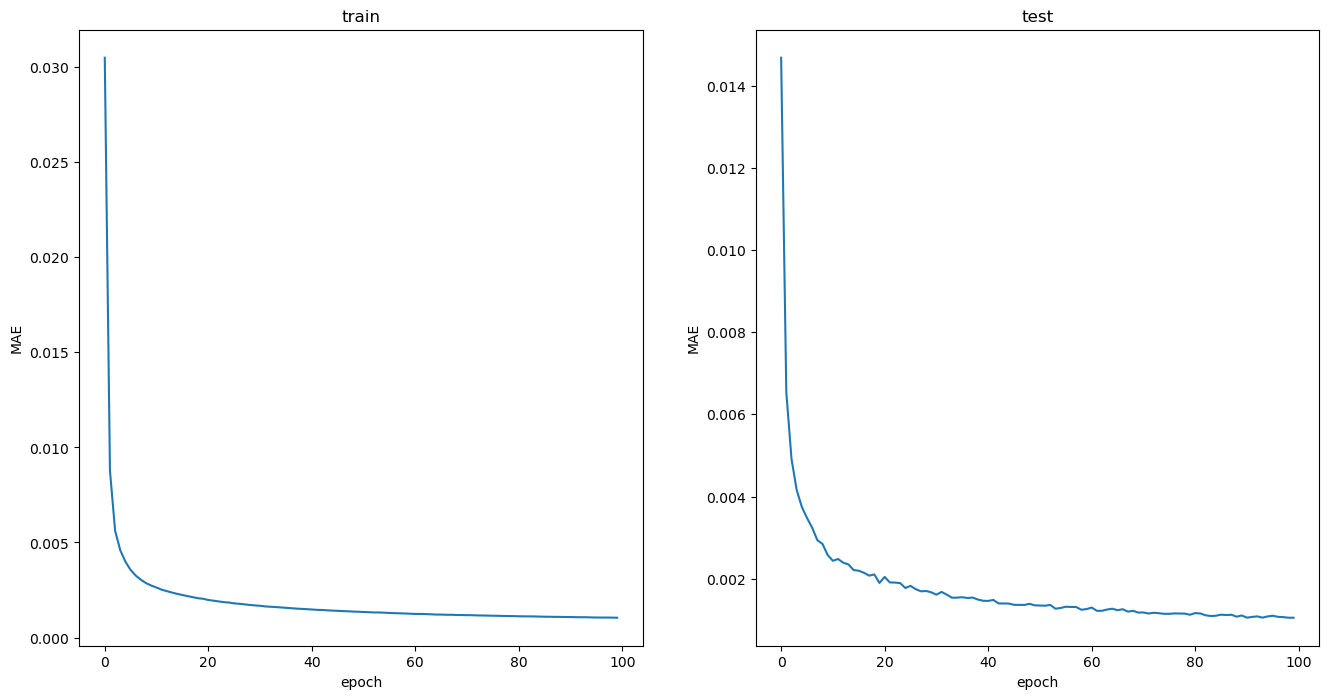

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax[0].plot(list(range(len(lossesTrain))), lossesTrain)
ax[1].plot(list(range(len(lossesTest))), lossesTest)
ax[0].set_title("train")
ax[1].set_title("test")
ax[0].set_xlabel("epoch")
ax[1].set_xlabel("epoch")
ax[0].set_ylabel("MAE")
ax[1].set_ylabel("MAE")
plt.show()

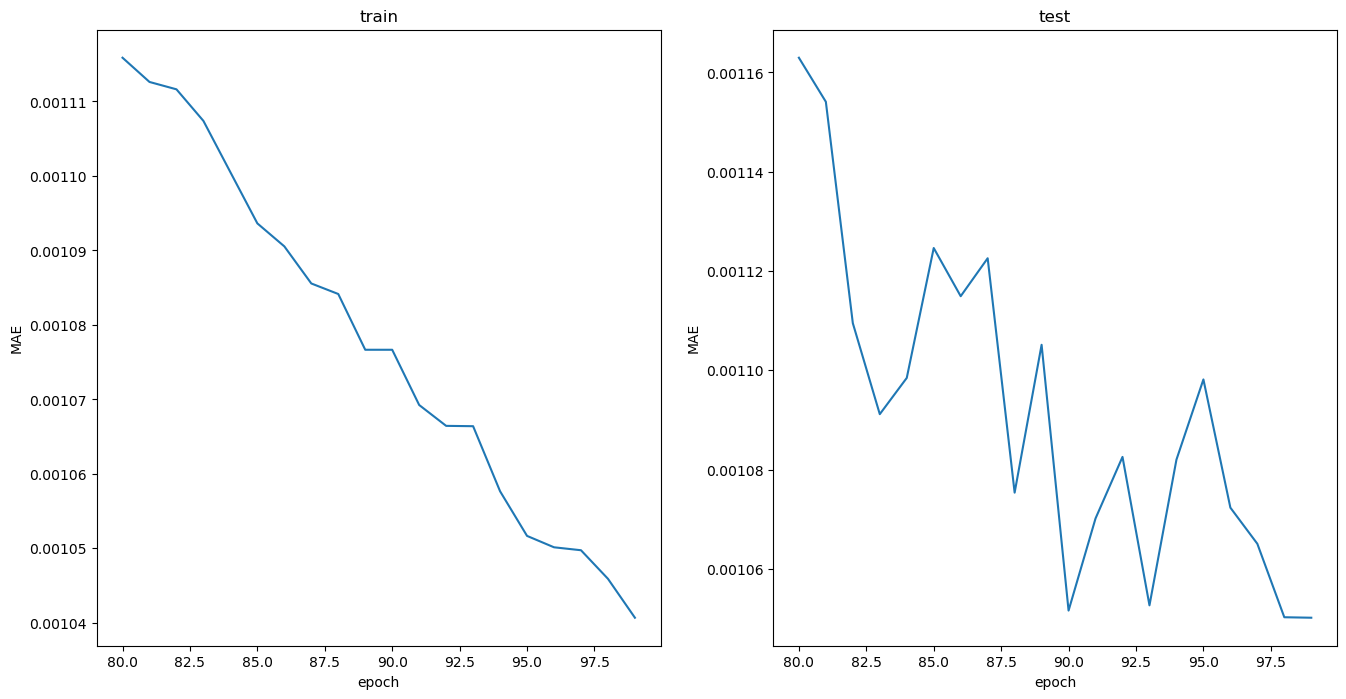

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax[0].plot(list(range(len(lossesTrain)))[80:], lossesTrain[80:])
ax[1].plot(list(range(len(lossesTest)))[80:], lossesTest[80:])
ax[0].set_title("train")
ax[1].set_title("test")
ax[0].set_xlabel("epoch")
ax[1].set_xlabel("epoch")
ax[0].set_ylabel("MAE")
ax[1].set_ylabel("MAE")
plt.show()

In [70]:
# for key, val in losses.items():
#     print(min(val))
min(lossesTrain), min(lossesTest)

(0.0010406913135999015, 0.0010501419892534614)

In [ ]:
#writePredict(model(nonTensorInput, tensorInput), 'TPF150.1/pred/')

In [22]:
with open('tbnn.pickle', 'wb') as f:
    pickle.dump(model, f)